counties: ['York', 'Penobscot', 'Kennebec', 'Oxford', 'Piscataquis', 'Lincoln', 'Cumberland', 'Hancock', 'Knox', 'Franklin', 'Aroostook', 'Somerset', 'Androscoggin', 'Sagadahoc', 'Washington', 'Waldo']
districts: ['1', '2']


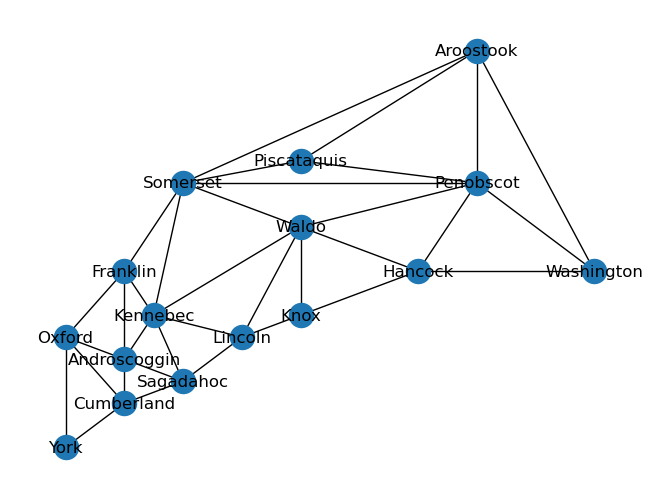

In [2]:
# Optimal Maine Congressional Redistricting

import gurobipy as gp
from gurobipy import GRB

# County data 
county_population = {
    'York': 211972,
    'Penobscot': 152199,
    'Kennebec':  123642,
    'Oxford': 57777,
    'Piscataquis': 16800,
    'Lincoln':  35237,
    'Cumberland': 303069,
    'Hancock': 55478,
    'Knox':  40607,
    'Franklin': 29456,
    'Aroostook': 67105,
    'Somerset':  50477,
    'Androscoggin':  111139,
    'Sagadahoc': 36699,
    'Washington': 31095,
    'Waldo':  39607,
}

districts = ["1","2"]

neighbors  = {
    ('York', 'Oxford'),
    ('York', 'Cumberland'),
    ('Penobscot', 'Piscataquis'),
    ('Penobscot', 'Hancock'),
    ('Penobscot', 'Aroostook'),
    ('Penobscot', 'Somerset'),
    ('Penobscot', 'Washington'),
    ('Penobscot', 'Waldo'),
    ('Kennebec', 'Lincoln'),
    ('Kennebec', 'Franklin'),
    ('Kennebec', 'Somerset'),
    ('Kennebec', 'Androscoggin'),
    ('Kennebec', 'Sagadahoc'),
    ('Kennebec', 'Waldo'),
    ('Oxford', 'Cumberland'),   
    ('Oxford', 'Franklin'),   
    ('Oxford', 'Androscoggin'),   
    ('Piscataquis', 'Aroostook'),
    ('Piscataquis', 'Somerset'),
    ('Lincoln', 'Knox'),   
    ('Lincoln', 'Sagadahoc'),   
    ('Lincoln', 'Waldo'),  
    ('Cumberland', 'Androscoggin'),   
    ('Cumberland', 'Sagadahoc'), 
    ('Hancock', 'Knox'),   
    ('Hancock', 'Washington'),   
    ('Hancock', 'Waldo'), 
    ('Knox', 'Waldo'),
    ('Franklin', 'Somerset'),   
    ('Franklin', 'Androscoggin'), 
    ('Aroostook', 'Somerset'),   
    ('Aroostook', 'Washington'), 
    ('Somerset', 'Waldo'),
    ('Androscoggin', 'Sagadahoc') 
}

counties = [key for key in county_population]

print("counties:", counties)

print("districts:", districts)

import networkx as nx

# Create a directed graph
map = nx.Graph()

# Add nodes
map.add_nodes_from(counties)

pos = {'York': [1,1],
    'Penobscot': [8,7],
    'Kennebec':  [2.5,4],
    'Oxford': [1,3.5],
    'Piscataquis': [5,7.5],
    'Lincoln':  [4,3.5],
    'Cumberland': [2,2],
    'Hancock': [7,5],
    'Knox':  [5,4],
    'Franklin': [2,5],
    'Aroostook': [8,10],
    'Somerset':  [3,7],
    'Androscoggin': [2,3],
    'Sagadahoc': [3,2.5],
    'Washington': [10,5],
    'Waldo':  [5,6] 
}

# Add arcs
arcs = [key for key in neighbors]

map.add_edges_from(arcs)

# Draw the map
nx.draw(map, pos,with_labels = True) 

In [3]:
#Model
m = gp.Model('ME Congressional Districts')

# Define decision variables
x = m.addVars(counties, districts, vtype=gp.GRB.BINARY, name = 'x')
y = m.addVars(map.edges, name = 'y')

# Add assignment constraints
m.addConstrs((gp.quicksum(x[c,d] for d in districts) == 1 for c in counties), name = 'district assignment')

# Add cut edge constraints
m.addConstrs((x[edge[0],d] - x[edge[1],d] <= y[edge] for edge in map.edges for d in districts), name = 'cut edges')

# Add population constraint
# ideal pop. = total pop. / total districts = 1362359/2 = 681180
# +/- o.5% population deviation UB = 684586, LB = 677774

m.addConstrs((gp.quicksum(x[c,d]*county_population[c] for c in counties) >= 677774 for d in districts), name = 'lower bound')
m.addConstrs((gp.quicksum(x[c,d]*county_population[c] for c in counties) <= 684586 for d in districts), name = 'upper bound')

# Set objective function
m.setObjective(gp.quicksum(y), GRB.MINIMIZE)

# Solve!
m.optimize()

#display solution variables

for v in m.getVars():
    print(v.varName, v.X) 

        

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G320)

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 88 rows, 66 columns and 300 nonzeros
Model fingerprint: 0x9754233d
Variable types: 34 continuous, 32 integer (32 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Found heuristic solution: objective 19.0000000
Presolve removed 18 rows and 16 columns
Presolve time: 0.02s
Presolved: 70 rows, 50 columns, 236 nonzeros
Variable types: 0 continuous, 50 integer (50 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   16   

/var/folders/h_/7b_j1zjs4111d5m84w3gz79w0000gn/T/ipykernel_859/854517274.py:23: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  m.setObjective(gp.quicksum(y), GRB.MINIMIZE)


Solution count 2: 5 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
x[York,1] 0.0
x[York,2] 1.0
x[Penobscot,1] 1.0
x[Penobscot,2] 0.0
x[Kennebec,1] 1.0
x[Kennebec,2] 0.0
x[Oxford,1] 0.0
x[Oxford,2] 1.0
x[Piscataquis,1] 1.0
x[Piscataquis,2] 0.0
x[Lincoln,1] 1.0
x[Lincoln,2] 0.0
x[Cumberland,1] 0.0
x[Cumberland,2] 1.0
x[Hancock,1] 1.0
x[Hancock,2] 0.0
x[Knox,1] 1.0
x[Knox,2] 0.0
x[Franklin,1] 1.0
x[Franklin,2] 0.0
x[Aroostook,1] 1.0
x[Aroostook,2] 0.0
x[Somerset,1] 1.0
x[Somerset,2] 0.0
x[Androscoggin,1] 0.0
x[Androscoggin,2] 1.0
x[Sagadahoc,1] 1.0
x[Sagadahoc,2] 0.0
x[Washington,1] 1.0
x[Washington,2] 0.0
x[Waldo,1] 1.0
x[Waldo,2] 0.0
y[York,Cumberland] 0.0
y[York,Oxford] 0.0
y[Penobscot,Somerset] 0.0
y[Penobscot,Washington] 0.0
y[Penobscot,Waldo] 0.0
y[Penobscot,Piscataquis] 0.0
y[Penobscot,Hancock] 0.0
y[Penobscot,Aroostook] 0.0
y[Kennebec,Sagadahoc] 0.0
y[Kennebec,Androscoggin] 1.0
y[Kennebec,Somerset] 0.0